# Project 3 - 20201514 이현수
- Keras를 사용하여 spam mail dataset을 분류할 수 있는 딥러닝 모델을 만듭니다.
- data: 5,171 spam mail messages
- 데이터의 불용어는 제거되어 있습니다.
- target: spam (1) or ham (0)

https://www2.aueb.gr/users/ion/data/enron-spam/

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import requests

URL = "https://raw.githubusercontent.com/crazytb/schadvmachinelearning/main/spam_ham_dataset_cleaned.csv"
response = requests.get(URL)
open("spam_ham_dataset_cleaned.csv", "wb").write(response.content)
df = pd.read_csv("spam_ham_dataset_cleaned.csv")

In [2]:
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num                                       text_cleaned  
0          0  Subject: enron methanol meter 988291 follow no...  
1          0  Subject: hpl nom january 9 2001 see attached f...  
2          0  Subject: neon retreat ho ho ho around wonderfu...  
3          1  Subject: photoshop windows office cheap main t...  
4          0  Subject: indian springs deal book teco pvr rev...  


In [3]:
df.shape

(5171, 5)

In [4]:
from sklearn.model_selection import train_test_split

x = df["text_cleaned"].to_numpy()
y = df["label_num"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Distibution of the sample data

Mean number of words: 114.88950676982591
Median number of words: 61.0


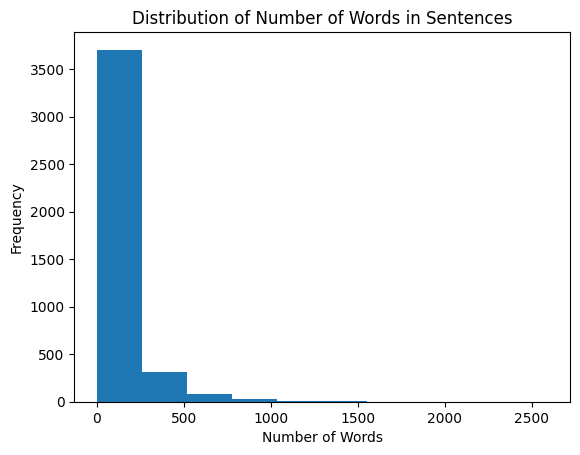

In [5]:
# 단어수 계산
word_counts = [len(sentence.split()) for sentence in x_train]
mean_words = np.mean(word_counts)
median_words = np.median(word_counts)
print("Mean number of words:", mean_words)
print("Median number of words:", median_words)

# 그래프 그리기
plt.hist(word_counts)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Sentences')
plt.show()

### Tokenization

In [6]:
max_features = 500
max_seq_length = 100

# Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization and make a TextVectorization layer.
vectorize_layer = layers.TextVectorization(max_tokens=max_features, output_sequence_length=max_seq_length)
vectorize_layer.adapt(x_train)

print("x_train[0]:", x_train[0])
print("x_train[0]:", vectorize_layer(x_train[0]))

x_train[0]: Subject: mlle joy wilson capitale investissement cher es honn?te investisseurs je suis contact?s par une cliente fiable mlle joy wilson la recherche un partenaire affaires pour investir la somme us 10 actuellement dans une banque de la c?te ivoire pour une entreprises profitables en europe la cliente est une fille un politicien feu martins wilson de la c?te ivoire qui ?t? tu?e pendant la crise socio politique donc un investisseur ou un individu l?galement inscrit avec la connaissance un profitable de pouvoir travaille avec l argent de telle quantit? pour la p?riode de cinq ann?es ou est moins exig? pour un buts investissement avant l ?lection prochaine dans le pays pr?freable dans l europe les documents pour prouv? la source des fonds est disponible pour votre confirmation et est conscient que le propri?taire de ces fonds d?sirent la confidence et le professionalisme absolue pour mieux g?r? ces fonds il vous pla?t la note que n importe quelle application hors europe n est p

### One-hot encoding (Use the vectorize layer that has been made above)

In [7]:
from tensorflow.keras.utils import to_categorical

# 훈련 데이터와 테스트 데이터를 토큰화
x_train_vl = vectorize_layer(x_train)
x_test_vl = vectorize_layer(x_test)

# 원-핫 인코딩 진행
x_train_oh = to_categorical(x_train_vl)
x_test_oh = to_categorical(x_test_vl)

print(x_train_oh[0])
print("x_train One-Hot encoding:", x_train_oh.shape)
print("x_test One-Hot encoding:", x_test_oh.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train_oh, y_train, test_size=0.2, random_state=42)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
x_train One-Hot encoding: (4136, 100, 500)
x_test One-Hot encoding: (1035, 100, 500)


### Make sequential model and evaluate it

In [8]:
from keras.models import Model

# Make a sequential model
inputs = layers.Input(shape = (100, 500))
simple_rnn = layers.SimpleRNN(2, activation='tanh')(inputs)
dense = layers.Dense(1, activation='sigmoid')(simple_rnn)
RNN_model = Model(inputs=inputs, outputs=dense)
RNN_model.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
RNN_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = RNN_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 500)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 2)                 1006      
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
104/104 [==============================] - 14s 84ms/step - loss: 0.6934 - accuracy: 0.5148 - val_loss: 0.6914 - val_accuracy: 0.5374
Epoch 2/100
104/104 [==============================] - 8s 73ms/step - loss: 0.6883 - accuracy: 0.5541 - val_loss: 0.6869 - val_accuracy: 0.5785
Epoch 3/100
104/104 [=============

### Plotting history

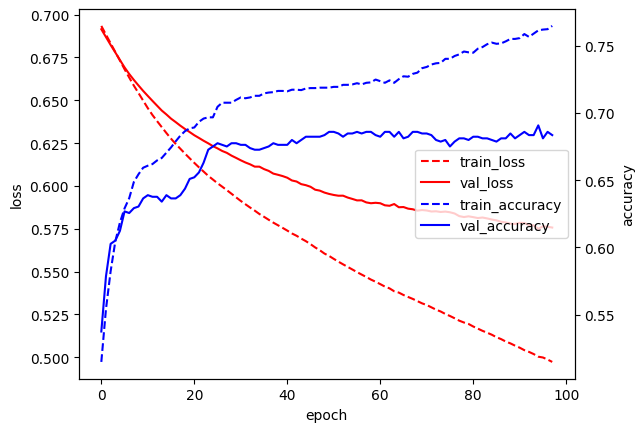

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#그림판 준비
fig, ax1 = plt.subplots()

# loss 그래프 ax1
ax1.plot(history.history['loss'], linestyle='--', color='red', label='train_loss')
ax1.plot(history.history['val_loss'], color='red', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

# accuracy 그래프 ax2
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], linestyle='--', color='blue', label='train_accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
ax2.set_ylabel('accuracy')

# 이름표 합치기
loss, loss_label = ax1.get_legend_handles_labels()
acc, acc_label = ax2.get_legend_handles_labels()
ax1.legend(loss + acc, loss_label + acc_label, loc='center right')

# 출력!
plt.show()
